## EDA

In [84]:
from pathlib import Path
import os, json, hashlib, random, shutil, time, zipfile, re, math
import cv2, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict, Counter

from IPython.display import display, Image, Markdown
pd.set_option('display.max_rows', None)  #	يخلي الجداول (DataFrame) تطلع كاملة في النوتبوك وما 

CONFIG

In [85]:
DATA_DIR = Path("/Users/amirah/Desktop/mubser_2nd/mubser2_model")  # ما اقدر ارفع الداتا على القيت هب فغيروا الباث هنا

# Make OUTPUT_DIR absolute so saved files are easy to find
OUTPUT_DIR = (Path().resolve() / "EDA_outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)   #يعمل إنشاء للمجلد و ما يعطي خطأ لو المجلد موجود اصلا 

# Image extensions we accept
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".gif"}

# Random seed for reproducibility (sampling)
RANDOM_SEED = 42   
random.seed(RANDOM_SEED)   #نضمن إن النتائج تبقى نفسها كل مرة نشغل الكود

# Limit how many images to scan per class for expensive checks (None => all)
SIZE_STATS_LIMIT_PER_CLASS = None  
DUP_SCAN_LIMIT_PER_CLASS   = None  

# Toggle optional visuals
ENABLE_PIE_CHART   = True  #رسم Pie Chart لتوزيع الصور حسب الفئات
ENABLE_SAMPLE_GRID = True  #يعرض Grid (شبكة) فيها عينات من الصور
ENABLE_DUP_CHECK   = True  #يفعل فحص التكرارات

هنا بما انهم نبهوا ع الرسومات سويت داله تعرض الروسومات هنا و تنحفظ في ملف خارجي عشان نوصل لها بسرعه

In [86]:
def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1 << 20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# show & save plots
def savefig_and_show(path, dpi=200):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    plt.show()
    plt.close()

def show_png_file(path):
    display(Image(filename=str(path)))
    
def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1 << 20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# show & save plots
def savefig_and_show(path, dpi=200):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    plt.show()
    plt.close()

def show_png_file(path):
    display(Image(filename=str(path)))

Report logger 

In [87]:
REPORT_PATH = OUTPUT_DIR / "eda_report.md"  #هذا الملف يجمع كل النصوص + الجداول + الصور اللي نطلعها

def report_start(title="data EDA Report"):    #ينشئ ملف التقرير ويكتب فيه العنوان الرئيسي
    REPORT_PATH.write_text(f"# {title}\n\n", encoding="utf-8")  #يبدأ تقرير جديد كل مرة

def report_section(title, text=None):  #يضيف عنوان فرعي 
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n\n## {title}\n\n")
        if text:
            f.write(text + "\n")

def _csv_preview_block(df, rows):
    # embed first rows as a code block CSV (avoids tabulate dependency)
    preview = df.head(rows).to_csv(index=False)
    return f"\n**Preview ({min(rows, len(df))} rows)**:\n\n```\n{preview}\n```\n"

def report_table(caption, df: pd.DataFrame, csv_name: str, show_rows=None):
    csv_path = OUTPUT_DIR / csv_name
    df.to_csv(csv_path, index=False)
    if show_rows is None:
        show_rows = len(df)
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n**{caption}** — saved CSV: `{csv_path.name}`\n")
        f.write(_csv_preview_block(df, show_rows))

def report_image(caption, img_path):
    rel = img_path.relative_to(OUTPUT_DIR)
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n**{caption}**\n\n![{caption}]({rel.as_posix()})\n")

def report_kv(title, d: dict):
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n\n## {title}\n\n")
        for k,v in d.items():
            f.write(f"- **{k}**: {v}\n")

# start report
report_start("data EDA Report")

 LIST CLASSES

In [88]:
def list_classes(data_dir: Path):
    if not data_dir.exists():
        raise SystemExit(f"[ERROR] Dataset not found at: {data_dir}")
    classes = sorted([d for d in data_dir.iterdir() if d.is_dir()], key=lambda p: p.name)
    (OUTPUT_DIR / "classes.txt").write_text("\n".join([c.name for c in classes]), encoding="utf-8")
    return classes

classes = list_classes(DATA_DIR)
report_section("Classes", f"Found **{len(classes)}** classes. Saved list to `classes.txt`.")
display(classes)

[PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/اب'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/اثنان'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/اخ'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/اربعه'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/اسف'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/الاثنين'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/الاحد'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/الاربعاء'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/الامارات العربيه المتحده'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/البحرين'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/الثلاثاء'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/الجمعة'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/الخميس'),
 PosixPath('/Users/amirah/Desktop/mubser_2nd/mubser2_model/السبت'),
 PosixPath('/Users/amirah

 COUNT PER CLASS + BAR CHART

Counting images per class: 100%|██████████| 89/89 [00:00<00:00, 712.21it/s]


,class,count
0,اب,1142
1,اثنان,18
2,اخ,11
3,اربعه,19
4,اسف,201
5,الاثنين,17
6,الاحد,37
7,الاربعاء,12
8,الامارات العربيه المتحده,11
9,البحرين,11


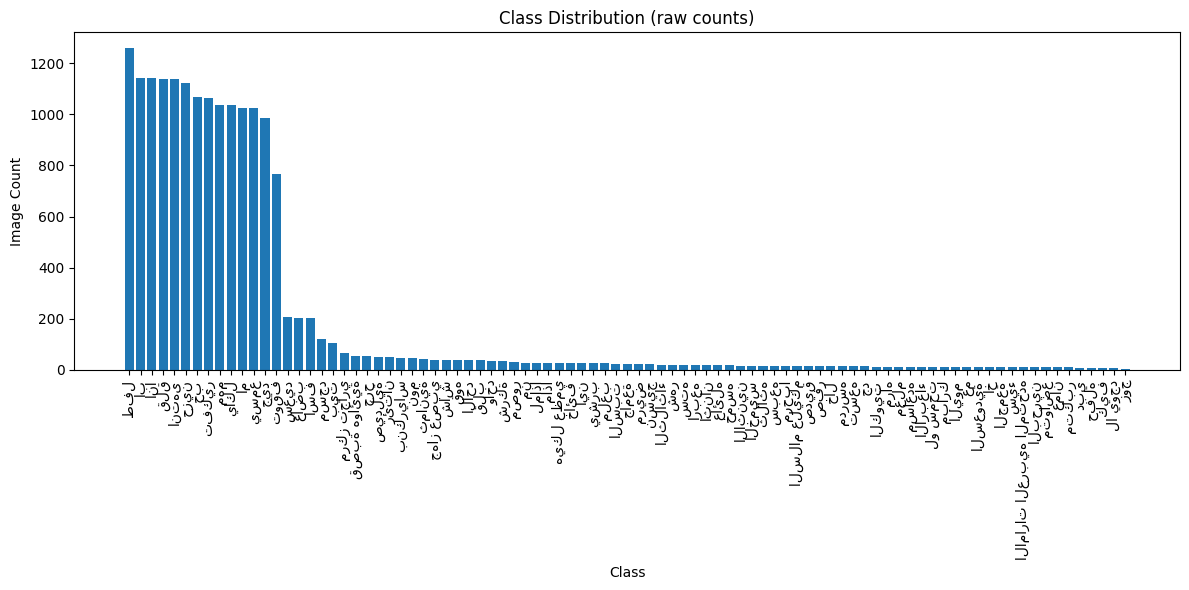

In [89]:
def count_images_per_class(classes):
    rows = []
    for c in tqdm(classes, desc="Counting images per class"):
        n = sum(1 for p in c.iterdir() if is_image(p))
        rows.append({"class": c.name, "count": n})
    df = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
    return df

df_counts = count_images_per_class(classes)
display(df_counts)
report_table("Class Counts", df_counts, "class_counts.csv", show_rows=len(df_counts))

df_sorted = df_counts.sort_values("count", ascending=False).reset_index(drop=True)
plt.figure(figsize=(12,6))
plt.bar(df_sorted["class"], df_sorted["count"])
plt.xticks(rotation=90)
plt.title("Class Distribution (raw counts)")
plt.xlabel("Class"); plt.ylabel("Image Count")
bar_path = OUTPUT_DIR / "class_distribution.png"
savefig_and_show(bar_path)
report_image("Class Distribution (bar)", bar_path)

ADD PERCENTAGES + PIE

,class,count,percentage
0,طفل,1258,7.256157
1,اب,1142,6.587068
2,انا,1142,6.587068
3,قلق,1138,6.563996
4,انتهى,1138,6.563996
5,حزين,1122,6.471708
6,حب,1066,6.148699
7,تفكير,1063,6.131395
8,مهم,1036,5.975659
9,ياكل,1036,5.975659


/var/folders/n7/8spcbrh50f3dfg_tvt66rsbm0000gn/T/ipykernel_60338/863437329.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


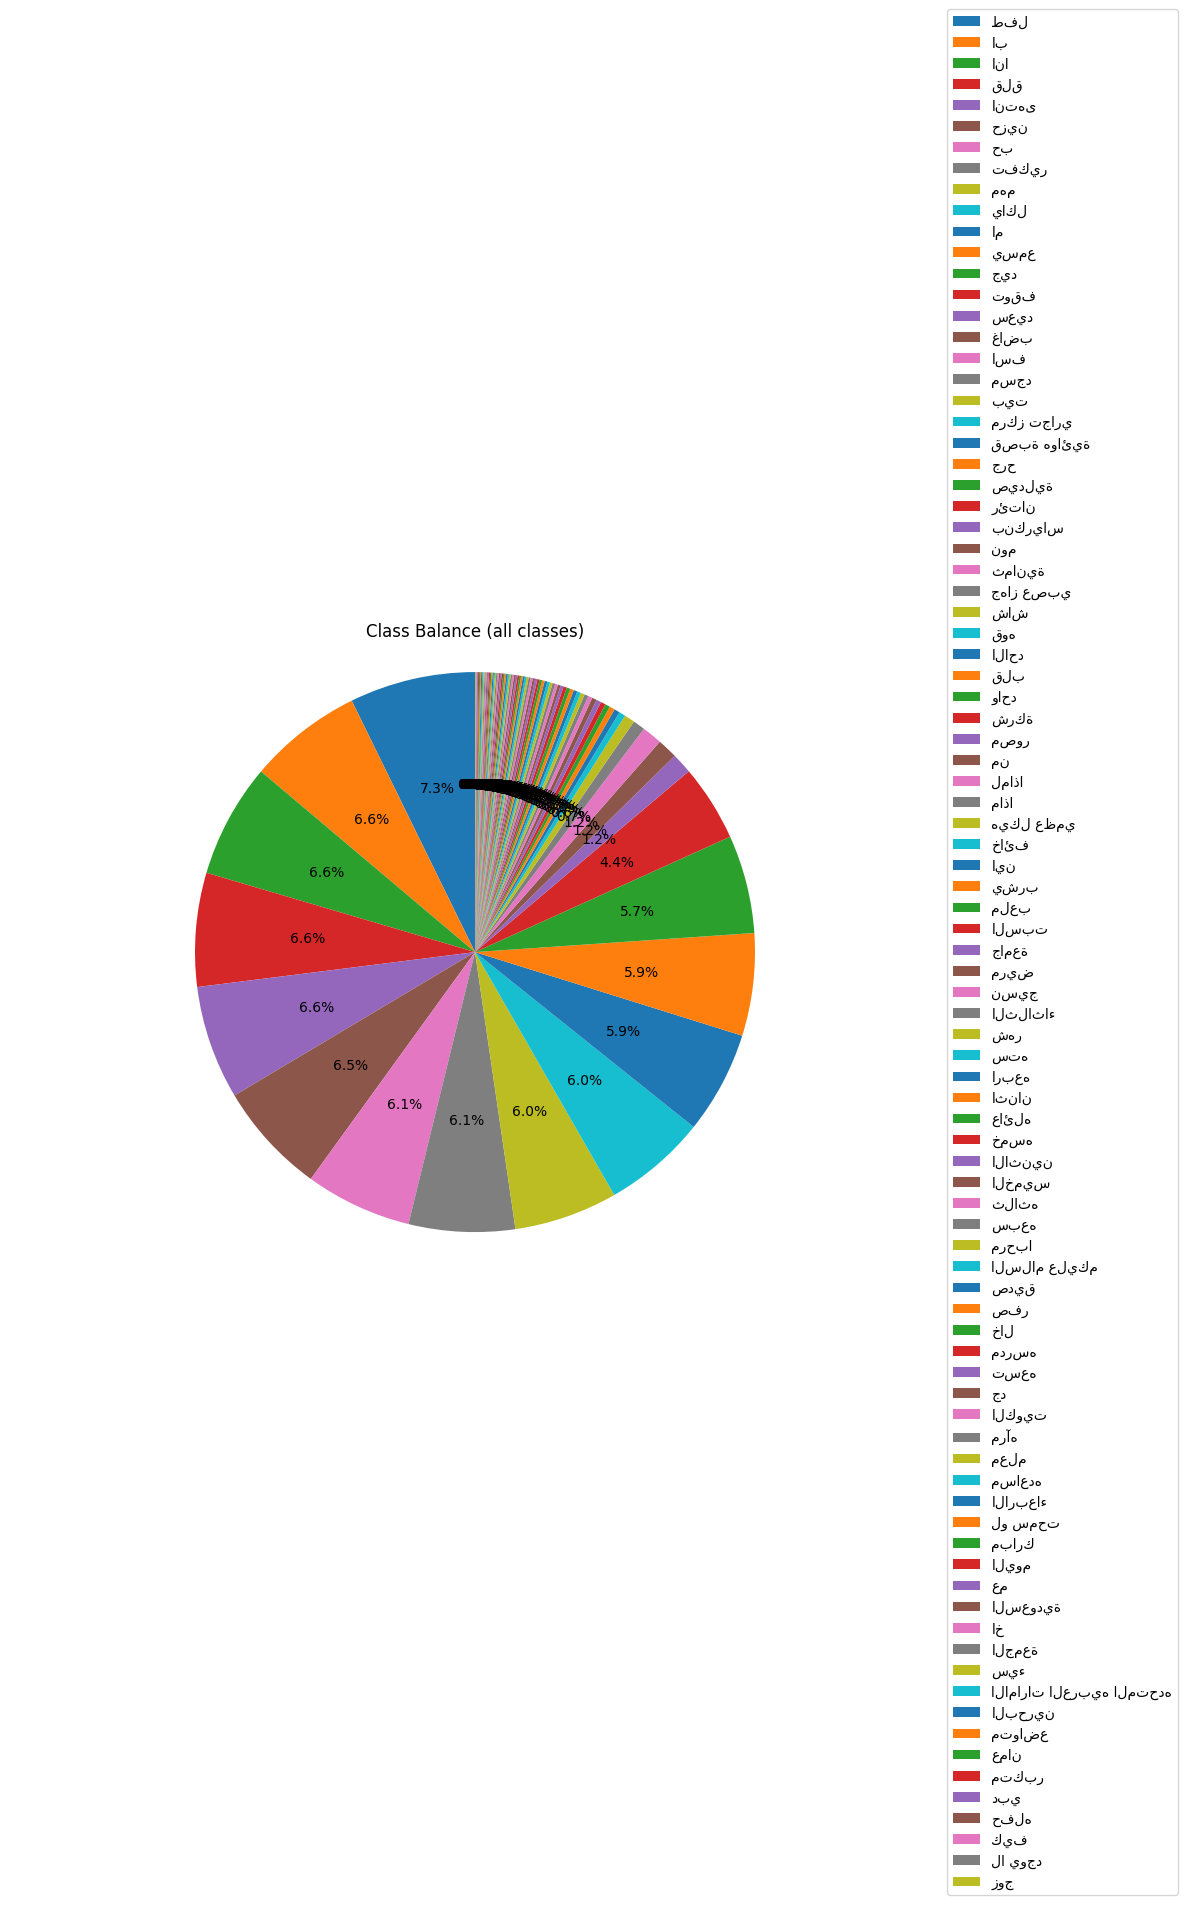

In [90]:
def add_percentages(df_counts: pd.DataFrame):
    total = int(df_counts["count"].sum())
    df2 = df_counts.copy()
    df2["percentage"] = (df2["count"] / total) * 100.0
    df2 = df2.sort_values("count", ascending=False).reset_index(drop=True)
    return df2

df_pct = add_percentages(df_counts)
display(df_pct)
report_table("Class Counts with Percentage", df_pct, "class_counts_with_percentage.csv", show_rows=len(df_pct))

if ENABLE_PIE_CHART:
    plt.figure(figsize=(12,8))
    plt.pie(df_pct["percentage"], autopct="%.1f%%", startangle=90)
    plt.title("Class Balance (all classes)")
    plt.axis('equal')
    plt.legend(df_pct["class"], loc="center left", bbox_to_anchor=(1, 0.5))
    pie_path = OUTPUT_DIR / "class_balance.png"
    savefig_and_show(pie_path)
    report_image("Class Balance (pie)", pie_path)

CORRUPTED IMAGES CHECK

Scanning corrupted images: 100%|██████████| 89/89 [01:40<00:00,  1.13s/it]


,class,corrupted
0,اب,0
45,سعيد,0
65,لو سمحت,0
64,لماذا,0
63,لا يوجد,0
62,كيف,0
61,قوه,0
60,قلق,0
59,قلب,0
58,قصبة هوائية,0


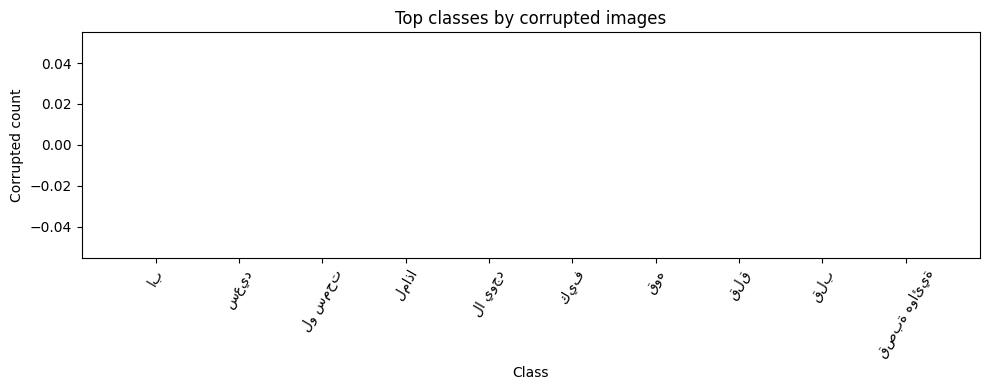

In [91]:
def find_corrupted_images(classes):
    bad_files, per_class = [], []
    for c in tqdm(classes, desc="Scanning corrupted images"):
        bad_in_class = 0
        for p in c.iterdir():
            if not is_image(p):
                continue
            im = safe_imread(p)
            if im is None:
                bad_files.append(str(p))
                bad_in_class += 1
        per_class.append({"class": c.name, "corrupted": bad_in_class})
    df_bad = pd.DataFrame(per_class).sort_values("corrupted", ascending=False)
    if bad_files:
        with open(OUTPUT_DIR / "corrupted_images.json", "w", encoding="utf-8") as f:
            json.dump(bad_files, f, ensure_ascii=False, indent=2)
    return bad_files, df_bad

bad_files, bad_df = find_corrupted_images(classes)
display(bad_df)
report_table("Corrupted Images per Class", bad_df, "corrupted_counts_per_class.csv", show_rows=len(bad_df))
report_section("Corrupted Summary", f"Total corrupted files: **{len(bad_files)}**" + (", saved to `corrupted_images.json`" if bad_files else ""))

# optional top-10 bar
top_bad = bad_df.head(10)
plt.figure(figsize=(10,4))
plt.bar(top_bad["class"], top_bad["corrupted"])
plt.xticks(rotation=60)
plt.title("Top classes by corrupted images")
plt.xlabel("Class"); plt.ylabel("Corrupted count")
corr_path = OUTPUT_DIR / "corrupted_top10.png"
savefig_and_show(corr_path)
report_image("Top classes by corrupted images", corr_path)

RANDOM SAMPLE GRID

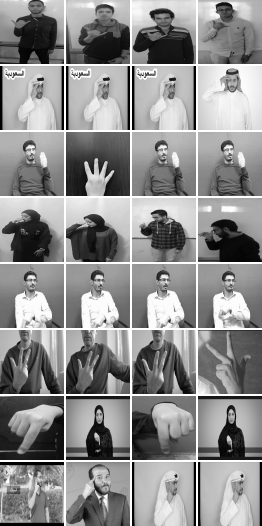

In [92]:
def save_sample_grid(classes, max_classes=8, samples_per_class=4, tile_size=(64,64)):
    try:
        chosen = random.sample(classes, k=min(max_classes, len(classes)))
    except ValueError:
        chosen = classes
    tiles = []
    for c in chosen:
        imgs = [p for p in c.iterdir() if is_image(p)]
        random.shuffle(imgs)
        imgs = imgs[:samples_per_class]
        for p in imgs:
            im = safe_imread(p, flags=cv2.IMREAD_GRAYSCALE)
            if im is None: 
                continue
            im = cv2.resize(im, tile_size, interpolation=cv2.INTER_AREA)
            tiles.append(im)
    if not tiles:
        return None
    rows, cols = max_classes, samples_per_class
    rows = min(rows, int(np.ceil(len(tiles)/max(1, cols))))
    h, w = tile_size
    pad = 2
    grid = np.full((rows*(h+pad)-pad, cols*(w+pad)-pad), 255, dtype=np.uint8)
    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(tiles): break
            rh, ch = r*(h+pad), c*(w+pad)
            grid[rh:rh+h, ch:ch+w] = tiles[idx]
            idx += 1
    out_path = OUTPUT_DIR / "sample_grid.png"
    cv2.imwrite(str(out_path), grid)
    return out_path

if ENABLE_SAMPLE_GRID:
    grid_path = save_sample_grid(classes, max_classes=8, samples_per_class=4, tile_size=(64,64))
    if grid_path:
        show_png_file(grid_path)
        report_image("Sample Grid", grid_path)

DUPLICATE CHECK

In [93]:

def find_duplicates_by_hash(classes, limit_per_class=None):
    dup_report, total_dups = {}, 0
    for c in tqdm(classes, desc="Duplicate scan (md5)"):
        files = [p for p in c.iterdir() if is_image(p)]
        if limit_per_class is not None:
            files = files[:limit_per_class]
        seen, dups = {}, []
        for p in files:
            try:
                h = md5_of_file(p)
            except Exception:
                continue
            if h in seen:
                dups.append(str(p))
            else:
                seen[h] = str(p)
        if dups:
            dup_report[c.name] = {"duplicates": dups, "kept_example": next(iter(seen.values()))}
            total_dups += len(dups)
    if dup_report:
        with open(OUTPUT_DIR / "duplicates_by_class.json", "w", encoding="utf-8") as f:
            json.dump(dup_report, f, ensure_ascii=False, indent=2)
    return dup_report, total_dups

dups, total_dups = ({}, 0)
if ENABLE_DUP_CHECK:
    dups, total_dups = find_duplicates_by_hash(classes, limit_per_class=DUP_SCAN_LIMIT_PER_CLASS)

report_section("Duplicates Summary", f"Total duplicate files (scanned): **{total_dups}**" + (" (see `duplicates_by_class.json`)" if total_dups else ""))

if dups:
    df_dups_per_class = (
        pd.DataFrame([{"class": k, "duplicates": len(v["duplicates"])} for k,v in dups.items()])
        .sort_values("duplicates", ascending=False)
        .reset_index(drop=True)
    )
    display(df_dups_per_class)
    report_table("Duplicates per Class", df_dups_per_class, "duplicates_per_class.csv", show_rows=len(df_dups_per_class))
else:
    print("No duplicates detected in the scanned set.")

Duplicate scan (md5): 100%|██████████| 89/89 [00:18<00:00,  4.78it/s]

No duplicates detected in the scanned set.


MAIN

In [94]:
# corrupted count (if file exists)
corr_json = OUTPUT_DIR / "corrupted_images.json"
corrupted_count = 0
if corr_json.exists():
    with open(corr_json, encoding="utf-8") as f:
        corrupted_count = len(json.load(f))

summary_md = (
    f"- Classes: **{len(classes)}**\n"
    f"- Total images: **{int(df_counts['count'].sum())}**\n"
    f"- Corrupted files: **{corrupted_count}**\n"
    f"- Duplicates (scanned): **{total_dups}**\n"
    f"- Outputs folder: `{OUTPUT_DIR.name}`\n"
    f"- Report file: `{REPORT_PATH.name}`\n"
)

display(Markdown("## Final Summary\n\n" + summary_md))
report_section("Final Summary", summary_md)

## Final Summary

- Classes: **89**
- Total images: **17337**
- Corrupted files: **0**
- Duplicates (scanned): **0**
- Outputs folder: `EDA_outputs`
- Report file: `eda_report.md`


## Cleaning

IMPORTS & CONFIG

In [95]:
# هنا بنحفظ النسخة النظيفة بعد التنظيف
CLEAN_DIR  = Path("./Data_Cleaned")

#مجلد لحفظ التقارير والسجلات أثناء التنظيف
CLEAN_LOGS = Path("./clean_logs")
CLEAN_LOGS.mkdir(parents=True, exist_ok=True) #عن التكرارات، الصور المحذوفة، الملخص

# اعدادات معالجة الصور
TARGET_SIZE = (64, 64)     # كل الصور بعد التنظيف راح تنعاد تحجيمها لمقاس 64
TO_GRAYSCALE = True        # نحول الصورة الى رمادي (مفيد للغة الاشارة)
IMG_EXTS      = {".png", ".jpg", ".jpeg", ".bmp"}

# التعامل مع التكرارات
DEDUP_SCOPE = "per_class"  # هذا يحدد كيف نفحص التكرارات
DEDUP_ACTION  = "delete"         # حذف نهائي من المصدر

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

HELPERS

In [96]:
def is_image(p: Path) -> bool:
    # نتاكد ان الملف صورة من الامتداد
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    # قراءة آمنة؛ ترجع None لو الصورة تالفة
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1<<20):
    #  بصمة الملف (للكشف عن التكرار)
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)
    return p

def write_json(obj, path: Path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

SCAN CLASSES & FILES

In [97]:
assert DATA_DIR.exists(), f"Dataset not found at {DATA_DIR}"

classes = sorted([d for d in DATA_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
assert classes, "No class folders found."

# دخلنا داخل كل كلاس وجمعنا الصور
all_items = []
for c in classes:
    files = [p for p in c.iterdir() if is_image(p)]
    for p in files:
        all_items.append({"class": c.name, "path": p})

df_files = pd.DataFrame(all_items) # حولناها لجدول (DataFrame)
print(f"[INFO] classes: {len(classes)} | images: {len(df_files)}")
display(df_files.head(3))

[INFO] classes: 89 | images: 17337


,class,path
0,اب,/Users/amirah/Desktop/mubser_2nd/mubser2_model...
1,اب,/Users/amirah/Desktop/mubser_2nd/mubser2_model...
2,اب,/Users/amirah/Desktop/mubser_2nd/mubser2_model...


In [98]:
df_files["class"].unique() #هوس اني اشيك كل مره

array(['اب', 'اثنان', 'اخ', 'اربعه', 'اسف', 'الاثنين', 'الاحد',
       'الاربعاء', 'الامارات العربيه المتحده', 'البحرين', 'الثلاثاء',
       'الجمعة', 'الخميس', 'السبت', 'السعودية', 'السلام عليكم', 'الكويت',
       'اليوم', 'ام', 'انا', 'انتهى', 'اين', 'بنكرياس', 'بيت', 'تسعه',
       'تفكير', 'توقف', 'ثلاثه', 'ثمانية', 'جامعة', 'جد', 'جرح',
       'جهاز عصبي', 'جيد', 'حب', 'حزين', 'حفله', 'خائف', 'خال', 'خمسه',
       'دبي', 'رئتان', 'زوج', 'سبعه', 'سته', 'سعيد', 'سيء', 'شاش', 'شركة',
       'شهر', 'صديق', 'صفر', 'صيدلية', 'طفل', 'عائله', 'عم', 'عمان',
       'غاضب', 'قصبة هوائية', 'قلب', 'قلق', 'قوه', 'كيف', 'لا يوجد',
       'لماذا', 'لو سمحت', 'ماذا', 'مبارك', 'متكبر', 'متواضع', 'مدرسه',
       'مرآه', 'مرحبا', 'مركز تجاري', 'مريض', 'مساعده', 'مسجد', 'مصور',
       'معلم', 'ملعب', 'من', 'مهم', 'نسيج', 'نوم', 'هيكل عظمي', 'واحد',
       'ياكل', 'يسمع', 'يشرب'], dtype=object)

DUPLICATE DETECTION

In [99]:
assert DEDUP_SCOPE == "per_class", "This notebook implements 'per_class' only."

dups_map = {}      # (class, hash) -> {"keep": Path, "dups": [Path, ...]}
hash_of_path = {}

for cls in tqdm(sorted(df_files["class"].unique()), desc="Hashing (per class)"):
    sub = df_files[df_files["class"] == cls]
    seen = {}  # hash -> first path (keep)
    for _, row in sub.iterrows():
        h = md5_of_file(row["path"])
        hash_of_path[row["path"]] = h
        key = (cls, h)
        if h in seen:
            if key not in dups_map:
                dups_map[key] = {"keep": seen[h], "dups": []}
            dups_map[key]["dups"].append(row["path"])
        else:
            seen[h] = row["path"]

# Normalize → table + list to remove (robust لو ما فيه مكررات)
to_remove = set()
dup_rows = []
for (cls, h), rec in dups_map.items():
    if not rec.get("dups"):
        continue
    for p in rec["dups"]:
        to_remove.add(p)
    dup_rows.append({
        "scope": cls,
        "hash":  h,
        "kept":  str(rec["keep"]),
        "duplicates": len(rec["dups"]),
    })

if dup_rows:
    df_dups = pd.DataFrame(dup_rows).sort_values("duplicates", ascending=False).reset_index(drop=True)
else:
    df_dups = pd.DataFrame(columns=["scope", "hash", "kept", "duplicates"])

print(f"[INFO] duplicates found (files to remove): {len(to_remove)}")
if not df_dups.empty:
    display(df_dups.head(10))
else:
    print("[INFO] No duplicate groups detected.")

# حفظ الملخصات
write_json({"duplicates_to_remove": list(map(str, to_remove))}, CLEAN_LOGS / "duplicates_to_remove.json")
df_dups.to_csv(CLEAN_LOGS / "duplicates_summary.csv", index=False)

Hashing (per class): 100%|██████████| 89/89 [00:18<00:00,  4.74it/s]

[INFO] duplicates found (files to remove): 0
[INFO] No duplicate groups detected.


APPLY DEDUP ACTION (DELETE)


In [100]:
assert DEDUP_ACTION == "delete", "Set DEDUP_ACTION='delete' to actually remove duplicates."

removed_list = []
for p in tqdm(list(to_remove), desc="Deleting duplicates"):
    try:
        p.unlink(missing_ok=True)  # حذف نهائي
        removed_list.append(str(p))
    except Exception as e:
        print("[WARN]", e)

write_json({"duplicates_removed": removed_list, "mode": DEDUP_ACTION}, CLEAN_LOGS / "duplicates_removed.json")
print(f"[INFO] duplicates removed from source: {len(removed_list)} | mode: {DEDUP_ACTION}")

# إعادة مسح بعد الحذف
all_items = []
for c in classes:
    for p in c.iterdir():
        if is_image(p):
            all_items.append({"class": c.name, "path": p})
df_files = pd.DataFrame(all_items)
print(f"[INFO] post-dedup images: {len(df_files)}")

Deleting duplicates: 0it [00:00, ?it/s]

[INFO] duplicates removed from source: 0 | mode: delete
[INFO] post-dedup images: 17337


RESCAN AFTER DEDUP


In [101]:
all_items = []
for c in classes:
    for p in c.iterdir():
        if is_image(p):
            all_items.append({"class": c.name, "path": p})
df_files = pd.DataFrame(all_items)
print(f"[INFO] post-dedup images: {len(df_files)}")

[INFO] post-dedup images: 17337


PREPROCESS HELPERS (GRAY + PAD + RESIZE)


In [102]:
def preprocess_img(img):
    #  نحول الصورة إلى رمادي لو كانت ملوّنة (BGR/BGRA)
    if TO_GRAYSCALE and img.ndim == 3:
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def resize_keep_aspect(img, target_size=(64, 64), pad_value=255):
    # نحافظ على نسبة الأبعاد عبر padding لمربع ثم resize نهائي
    tw, th = target_size  # width, height
    h, w = img.shape[:2]
    side = max(h, w)

    # كانفاس أبيض
    if img.ndim == 2:
        canvas = np.full((side, side), pad_value, dtype=img.dtype)
    else:
        canvas = np.full((side, side, img.shape[2]), pad_value, dtype=img.dtype)

    # وضع الصورة في المنتصف
    y0 = (side - h) // 2
    x0 = (side - w) // 2
    canvas[y0:y0 + h, x0:x0 + w] = img

    # تغيير المقاس النهائي
    out = cv2.resize(canvas, (tw, th), interpolation=cv2.INTER_AREA)
    return out

BUILD CLEANED DATASET

In [103]:
# تجهيز مجلدات الكلاسات في CLEAN_DIR
for c in classes:
    (CLEAN_DIR / c.name).mkdir(parents=True, exist_ok=True)

skipped_corrupted = 0
written_count = 0

progress = tqdm(total=len(df_files), desc="Copying -> CLEAN_DIR")
for _, row in df_files.iterrows():
    src = row["path"]
    cls = row["class"]

    # 1) قراءة آمنة
    im = safe_imread(src)
    if im is None:
        skipped_corrupted += 1
        progress.update(1)
        continue

    # 2) تحويل لرمادي (إن مفعّل)
    im = preprocess_img(im)

    # 3) padding + resize
    im = resize_keep_aspect(im, TARGET_SIZE, pad_value=255)

    # 4) حفظ كـ PNG (قناة وحدة لو رمادي)
    dst = CLEAN_DIR / cls / (src.stem + ".png")
    if im.ndim == 2:
        cv2.imwrite(str(dst), im)
    else:
        cv2.imwrite(str(dst), cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    written_count += 1
    progress.update(1)

progress.close()
print(f"[INFO] written: {written_count} | corrupted skipped: {skipped_corrupted}")

Copying -> CLEAN_DIR: 100%|██████████| 17337/17337 [02:10<00:00, 132.47it/s]

[INFO] written: 17337 | corrupted skipped: 0


VERIFY CLEANED COUNTS & SUMMARY

In [104]:
rows = []
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    n = sum(1 for p in c.iterdir() if is_image(p))
    rows.append({"class": c.name, "count": n})

df_clean_counts = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
display(df_clean_counts)

# حفظ التقارير
df_clean_counts.to_csv(CLEAN_LOGS / "clean_counts.csv", index=False)

total_clean = int(df_clean_counts["count"].sum())
summary = {
    "source_dir": str(DATA_DIR.resolve()),
    "clean_dir":  str(CLEAN_DIR.resolve()),
    "target_size": TARGET_SIZE,
    "to_grayscale": TO_GRAYSCALE,
    "dedup_scope":  DEDUP_SCOPE,
    "dedup_action": DEDUP_ACTION,
    "total_clean_images": total_clean
}
write_json(summary, CLEAN_LOGS / "clean_summary.json")

print("\n[DONE] Cleaning finished.")
print("Clean dir:", CLEAN_DIR.resolve())
print("Total images:", total_clean)

,class,count
0,اب,1142
1,اثنان,18
2,اخ,11
3,اربعه,19
4,اسف,201
5,الاثنين,17
6,الاحد,37
7,الاربعاء,12
8,الامارات العربيه المتحده,11
9,البحرين,11



[DONE] Cleaning finished.
Clean dir: /Users/amirah/Desktop/mubser_2nd/Data_Cleaned
Total images: 17337


SAMPLE GRID FROM CLEANED 


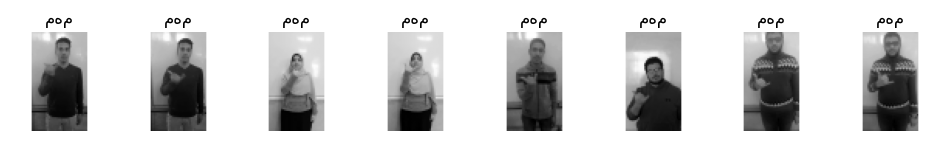

Final total images after cleaning: 17337


In [105]:
classes_clean = sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
if classes_clean:
    sample_class = random.choice(classes_clean)
    sample_images = list(sample_class.glob("*.png"))[:8]

    if sample_images:
        plt.figure(figsize=(12, 3))
        for i, img_path in enumerate(sample_images, 1):
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            plt.subplot(1, len(sample_images), i)
            plt.imshow(img, cmap="gray")
            plt.title(sample_class.name)
            plt.axis("off")
        plt.show()
print("Final total images after cleaning:", total_clean)

Total images after cleaning: 17337


,class,count
0,طفل,1258
1,اب,1142
2,انا,1142
3,قلق,1138
4,انتهى,1138
5,حزين,1122
6,حب,1066
7,تفكير,1063
8,مهم,1036
9,ياكل,1036


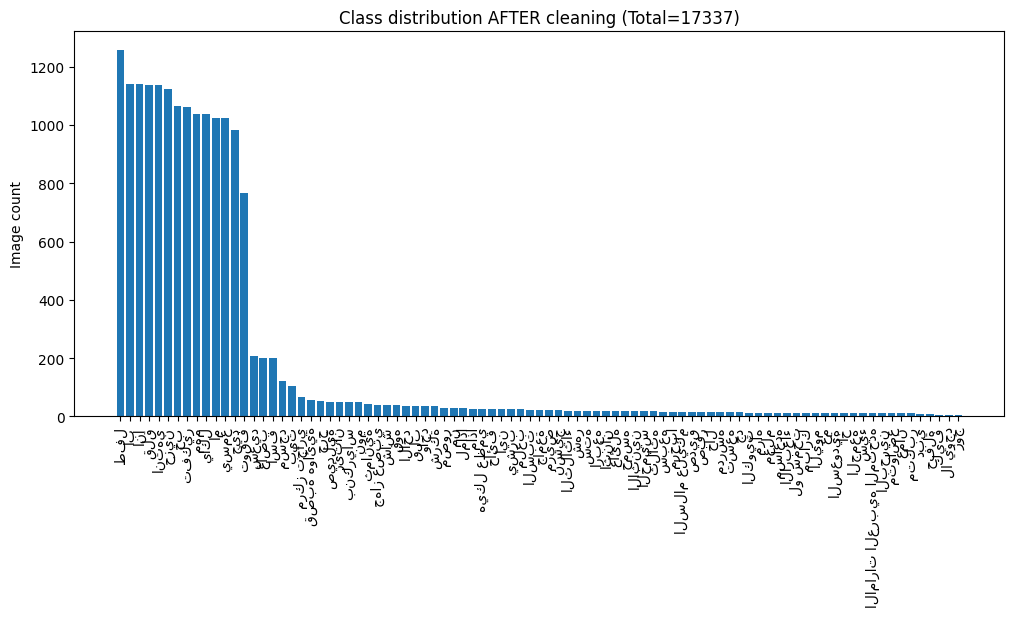

In [106]:
# عدّ الصور في CLEAN_DIR
rows = []
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    n = sum(1 for p in c.iterdir() if is_image(p))
    rows.append({"class": c.name, "count": n})

df_clean_counts = pd.DataFrame(rows).sort_values("count", ascending=False).reset_index(drop=True)

# إجمالي الصور
total_clean = int(df_clean_counts["count"].sum())
print("Total images after cleaning:", total_clean)
display(df_clean_counts.head(10))   # نعرض أول 10 كلاسات فقط (للإيجاز)

# رسم بسيط
plt.figure(figsize=(12,5))
plt.bar(df_clean_counts["class"], df_clean_counts["count"])
plt.xticks(rotation=90)
plt.ylabel("Image count")
plt.title(f"Class distribution AFTER cleaning (Total={total_clean})")
plt.show()

## Splitting

Split: 80% train, 10% val, 10% test

CONFIG

In [107]:
# CLEAN_DIR هو مجلد النسخة النظيفة اللي خلّصناها بالتنظيف
CLEAN_DIR = Path("./data_Cleaned")      # عدّلي المسار إذا لزم
SPLIT_DIR = Path("./data_Split")        # هنا راح نحط train/val/test
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

#  نسب التقسيم — 80/10/10
TRAIN_RATIO = 0.8
VAL_RATIO   = 0.1
TEST_RATIO  = 0.1
assert abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) < 1e-6, "Ratios must sum to 1."

# ثبّت العشوائية
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp"}

def is_image(p: Path) -> bool:
    """Return True if file extension is an image."""
    return p.suffix.lower() in IMG_EXTS

SCAN CLEANED

In [108]:
# نجمع كل الملفات المصنّفة (class folders) من CLEAN_DIR
assert CLEAN_DIR.exists(), f"Cleaned dataset not found: {CLEAN_DIR}"

classes = sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
assert classes, "No class folders found in CLEAN_DIR."

items = []
for c in classes:
    for p in c.iterdir():
        if is_image(p):
            items.append({"class": c.name, "path": p})

df = pd.DataFrame(items)
print(f"[INFO] classes: {len(classes)} | images: {len(df)}")

[INFO] classes: 89 | images: 17337


STRATIFIED SPLIT (per class)

In [109]:
#  نقسم داخل كل كلاس إلى 3 قوائم حسب النسب (مع خلط عشوائي ثابت)
def stratified_split_paths(paths, train_ratio, val_ratio, test_ratio, seed=RANDOM_SEED):
    n = len(paths)
    idx = list(range(n))
    random.Random(seed).shuffle(idx)  # تثبيت العشوائية لكل استدعاء
    n_train = int(round(n * train_ratio))
    n_val   = int(round(n * val_ratio))
    n_test  = n - n_train - n_val     # الباقي للتست لتجنب أثر التقريب

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train+n_val]
    test_idx  = idx[n_train+n_val:]

    train = [paths[i] for i in train_idx]
    val   = [paths[i] for i in val_idx]
    test  = [paths[i] for i in test_idx]
    return train, val, test

REATE DEST FOLDERS


In [110]:
#  نجهّز مجلدات الوجهات لكل split ولكل class
for split in ["train", "val", "test"]:
    for c in classes:
        (SPLIT_DIR / split / c.name).mkdir(parents=True, exist_ok=True)

SPLIT & COPY FILES


In [111]:
#  نقسّم وننسخ الملفات إلى المجلدات المناسبة
split_rows = []

for c in classes:
    cls = c.name
    paths = [p for p in c.iterdir() if is_image(p)]
    train_paths, val_paths, test_paths = stratified_split_paths(
        paths, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, seed=RANDOM_SEED
    )

    # نسخ الملفات
    for split_name, plist in [("train", train_paths), ("val", val_paths), ("test", test_paths)]:
        for src in plist:
            dst = SPLIT_DIR / split_name / cls / src.name
            shutil.copy2(src, dst)
            split_rows.append({"split": split_name, "class": cls, "path": dst})

df_split = pd.DataFrame(split_rows)
print("[INFO] split done.")
print("Target folder:", SPLIT_DIR.resolve())

[INFO] split done.
Target folder: /Users/amirah/Desktop/mubser_2nd/data_Split



COUNTS (PER SPLIT & CLASS)

In [112]:
#  نحسب عدد الصور لكل كلاس داخل كل split
def count_by_split(df_split: pd.DataFrame) -> pd.DataFrame:
    return (df_split.groupby(["split", "class"])["path"].count()
            .reset_index()
            .rename(columns={"path": "count"})
            .sort_values(["split", "class"])
            .reset_index(drop=True))

df_counts = count_by_split(df_split)
display(df_counts)

# NOTE (Arabic): ملخص سريع بعد التقسيم — كم صورة في كل split إجمالًا
summary = (df_split.groupby(["split"])["path"].count()
           .reset_index()
           .rename(columns={"path": "total_images"}))
display(summary)

# نحفظ الجداول كـ CSV مرجع
df_counts.to_csv(SPLIT_DIR / "class_counts_per_split.csv", index=False)
summary.to_csv(SPLIT_DIR / "split_totals.csv", index=False)

,split,class,count
0,test,اب,114
1,test,اثنان,2
2,test,اخ,1
3,test,اربعه,2
4,test,اسف,20
5,test,الاثنين,1
6,test,الاحد,3
7,test,الاربعاء,1
8,test,الامارات العربيه المتحده,1
9,test,البحرين,1


,split,total_images
0,test,1727
1,train,13874
2,val,1736


VISUALIZE: GROUPED BAR CHART


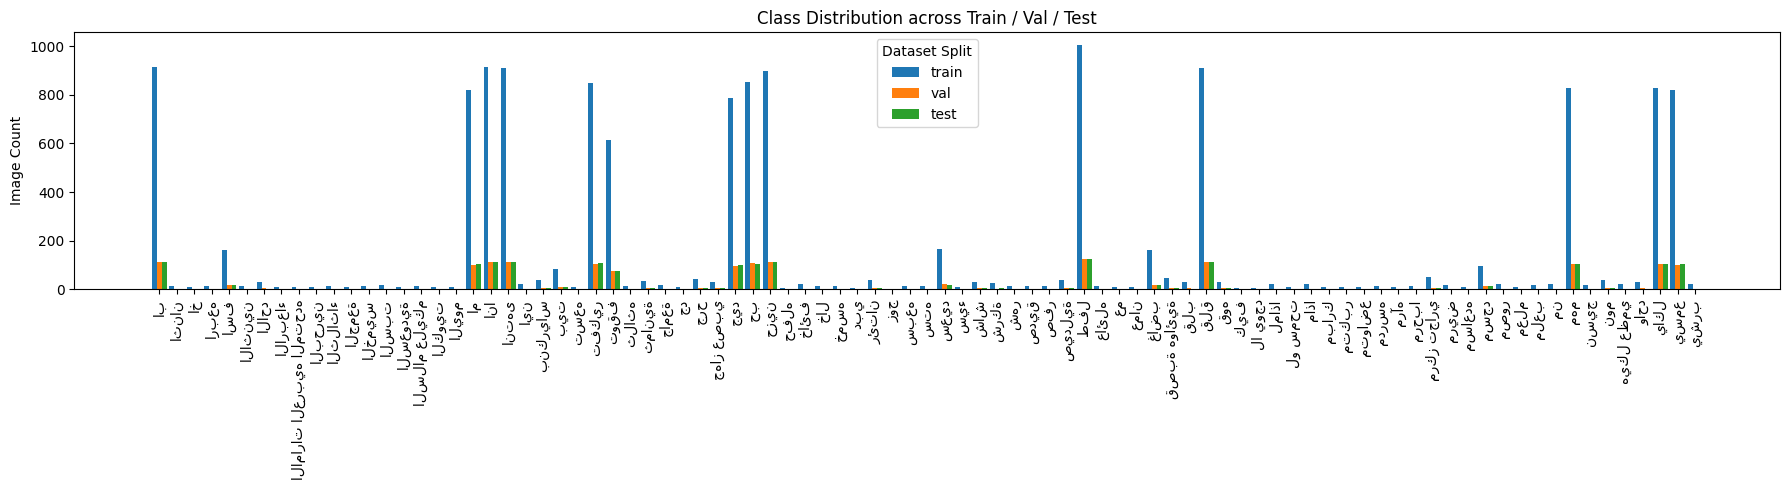

In [113]:
# مقارنة توزيع الكلاسات بين train/val/test (بدون seaborn)
dfp = df_counts.pivot(index="class", columns="split", values="count").fillna(0).sort_index()
splits = ["train", "val", "test"]
classes_order = dfp.index.tolist()

x = np.arange(len(classes_order))
width = 0.28

plt.figure(figsize=(18, 5))
for i, s in enumerate(splits):
    plt.bar(x + (i - 1) * width, dfp[s].values, width, label=s)

plt.xticks(x, classes_order, rotation=90)
plt.ylabel("Image Count")
plt.title("Class Distribution across Train / Val / Test")
plt.legend(title="Dataset Split")
plt.tight_layout()
plt.show()

	تأكيد أن التقسيم فعلاً 80/10/10 لكل كلاس

In [114]:
chk = df_counts.pivot(index="class", columns="split", values="count").fillna(0)
chk["total"] = chk.sum(axis=1)
chk["train%"] = (chk["train"]/chk["total"]*100).round(1)
chk["val%"]   = (chk["val"]/chk["total"]*100).round(1)
chk["test%"]  = (chk["test"]/chk["total"]*100).round(1)
display(chk[["train%","val%","test%"]])

split,train%,val%,test%
class,,,
اب,80.0,10.0,10.0
اثنان,77.8,11.1,11.1
اخ,81.8,9.1,9.1
اربعه,78.9,10.5,10.5
اسف,80.1,10.0,10.0
الاثنين,82.4,11.8,5.9
الاحد,81.1,10.8,8.1
الاربعاء,83.3,8.3,8.3
الامارات العربيه المتحده,81.8,9.1,9.1


## Balance 

Balance TRAIN by Augmentation 

[INFO] Resizing completed to TARGET_MAX = 900


,class,count
0,اب,900
1,اثنان,400
2,اخ,400
3,اربعه,400
4,اسف,400
5,الاثنين,400
6,الاحد,400
7,الاربعاء,400
8,الامارات العربيه المتحده,400
9,البحرين,400


[INFO] Total (before): 49666
[INFO] Balancing finished to TARGET_MIN = 300


,class,count
0,اب,900
1,اثنان,400
2,اخ,400
3,اربعه,400
4,اسف,400
5,الاثنين,400
6,الاحد,400
7,الاربعاء,400
8,الامارات العربيه المتحده,400
9,البحرين,400


[INFO] Total (after): 49666


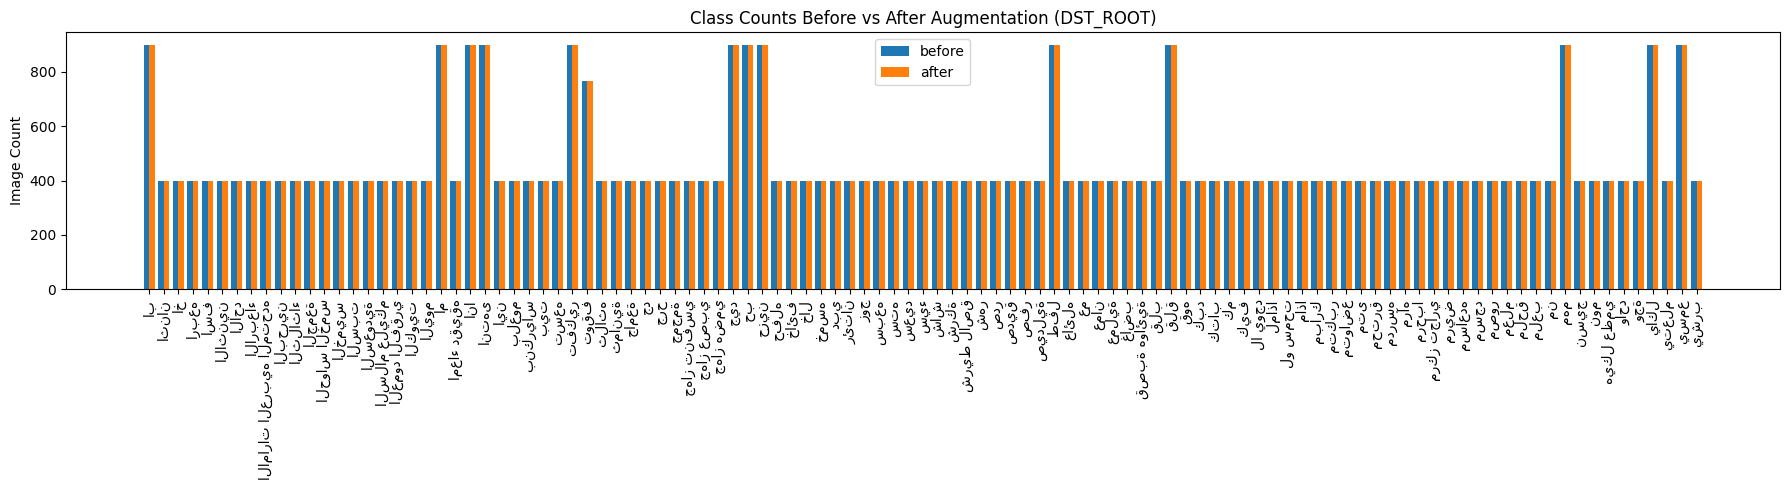

In [115]:
import os
import random
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== المسارات =====
SRC_ROOT = Path("/Users/amirah/Desktop/mubser_m2/Data_Cleaned")
DST_ROOT = Path("/Users/amirah/Desktop/mubser_m2/data_augmented")
DST_ROOT.mkdir(parents=True, exist_ok=True)

# حدود التوازن
TARGET_MIN = 300   # الحد الأدنى الذي نريد الوصول إليه
TARGET_MAX = 900   # الحد الأقصى الذي نريد تقليص الفئات إليه

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

random.seed(42)
np.random.seed(42)


def is_image(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in IMG_EXTS


def safe_augment(img: np.ndarray) -> np.ndarray:
    """Augmentation آمن لصور 64x64 رمادي."""
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    out = img.copy()
    h, w = out.shape[:2]

    if (h, w) != (64, 64):
        out = cv2.resize(out, (64, 64), interpolation=cv2.INTER_AREA)
        h, w = 64, 64

    # 3) إزاحة بسيطة
    tx = random.randint(-2, 2)
    ty = random.randint(-2, 2)
    M_shift = np.float32([[1, 0, tx], [0, 1, ty]])
    out = cv2.warpAffine(out, M_shift, (w, h), borderValue=255)

    # 4) Zoom بسيط حول المركز
    if random.random() < 0.7:
        scale = random.uniform(0.95, 1.05)
        new_w = int(w * scale)
        new_h = int(h * scale)

        zoomed = cv2.resize(out, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        if scale >= 1.0:
            x_start = (new_w - w) // 2
            y_start = (new_h - h) // 2
            out = zoomed[y_start:y_start + h, x_start:x_start + w]
        else:
            canvas = np.full((h, w), 255, dtype=np.uint8)
            x_start = (w - new_w) // 2
            y_start = (h - new_h) // 2
            canvas[y_start:y_start + new_h, x_start:x_start + new_w] = zoomed
            out = canvas

    # 5) سطوع/تباين بسيط
    alpha = random.uniform(0.9, 1.1)
    beta = random.randint(-8, 8)
    out = cv2.convertScaleAbs(out, alpha=alpha, beta=beta)

    # 6) Gamma correction بسيط
    if random.random() < 0.5:
        gamma = random.uniform(0.9, 1.1)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255
                          for i in range(256)]).astype("uint8")
        out = cv2.LUT(out, table)

    # 7) Gaussian blur خفيف
    if random.random() < 0.25:
        out = cv2.GaussianBlur(out, (3, 3), 0)

    # 8) نويز خفيف
    if random.random() < 0.7:
        noise = np.random.normal(0, 3, out.shape).astype(np.float32)
        out = np.clip(out.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    if out.shape != (64, 64):
        out = cv2.resize(out, (64, 64), interpolation=cv2.INTER_AREA)

    return out


# ===== لو data_augmented فاضي → ننسخ من Data_Cleaned =====
if not any(p.is_dir() for p in DST_ROOT.iterdir()):
    print("[INFO] data_augmented is empty. Copying classes from Data_Cleaned ...")
    for src_cls in SRC_ROOT.iterdir():
        if not src_cls.is_dir():
            continue

        dst_cls = DST_ROOT / src_cls.name
        dst_cls.mkdir(parents=True, exist_ok=True)

        for p in src_cls.iterdir():
            if not is_image(p):
                continue
            img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
            cv2.imwrite(str(dst_cls / p.name), img)
    print("[INFO] Copy done.")

# ===== تعريف الكلاسات من DST_ROOT =====
classes = sorted([d for d in DST_ROOT.iterdir() if d.is_dir()], key=lambda p: p.name)
assert classes, "[ERROR] No classes found in data_augmented/ after copy."

# --- تقليص الفئات الأكبر من 900 صورة ---
for cls_dir in classes:
    imgs = [p for p in cls_dir.iterdir() if is_image(p)]
    cur = len(imgs)

    if cur > TARGET_MAX:
        # تقليص الصور العشوائية
        imgs_to_keep = random.sample(imgs, TARGET_MAX)  # اختيار 900 صورة عشوائيًا
        for p in imgs:
            if p not in imgs_to_keep:
                os.remove(str(p))  # حذف الصور الزائدة

print("[INFO] Resizing completed to TARGET_MAX =", TARGET_MAX)

# --- احصاء قبل التوازن ---
def count_train():
    rows = []
    for c in classes:
        n = sum(1 for p in c.iterdir() if is_image(p))
        rows.append({"class": c.name, "count": n})
    return pd.DataFrame(rows).sort_values("class").reset_index(drop=True)

df_before = count_train()
display(df_before.head(10))
print("[INFO] Total (before):", int(df_before["count"].sum()))

# ===== التوازن: نزيد فقط اللي أقل من TARGET_MIN =====
for cls_dir in classes:
    imgs = [p for p in cls_dir.iterdir() if is_image(p)]
    cur = len(imgs)

    if cur >= TARGET_MIN:
        continue

    # نستخدم فقط الصور الأصلية (بدون aug_) كمصدر
    base_imgs = [p for p in imgs if "_aug_" not in p.stem]
    if not base_imgs:
        base_imgs = imgs  # احتياط

    need = TARGET_MIN - cur
    idx = 0

    with tqdm(total=need, desc=f"Augment {cls_dir.name}") as bar:
        while cur < TARGET_MIN and base_imgs:
            src = base_imgs[idx % len(base_imgs)]
            im = cv2.imread(str(src), cv2.IMREAD_GRAYSCALE)
            if im is None:
                idx += 1
                continue

            aug = safe_augment(im)

            out_name = f"{src.stem}_aug_{cur}.png"
            out_path = cls_dir / out_name

            if out_path.exists():
                idx += 1
                continue

            cv2.imwrite(str(out_path), aug)

            cur += 1
            idx += 1
            bar.update(1)

print("[INFO] Balancing finished to TARGET_MIN =", TARGET_MIN)

# --- احصاء بعد التوازن ---
df_after = count_train()
display(df_after.head(10))
print("[INFO] Total (after):", int(df_after["count"].sum()))

# --- رسم مقارنة قبل/بعد ---
merged = df_before.merge(df_after, on="class", suffixes=("_before", "_after"))
x = np.arange(len(merged))
width = 0.38

plt.figure(figsize=(18, 5))
plt.bar(x - width/2, merged["count_before"], width, label="before")
plt.bar(x + width/2, merged["count_after"], width, label="after")
plt.xticks(x, merged["class"], rotation=90)
plt.ylabel("Image Count")
plt.title("Class Counts Before vs After Augmentation (DST_ROOT)")
plt.legend()
plt.tight_layout()
plt.show()

## الحين بس ابي اتاكد

1) تأكيد عدم وجود تكرارات داخل CLEAN_DIR (داخل الكلاس وعلى مستوى كل الداتا)

In [116]:
def is_img(p): return p.suffix.lower() in IMG_EXTS

def md5_of_file(path, chunk=1<<20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for ch in iter(lambda: f.read(chunk), b""):
            h.update(ch)
    return h.hexdigest()

# --- per-class duplicates ---
dups_per_class = {}
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    seen = {}
    for p in tqdm([x for x in c.iterdir() if is_img(x)], desc=f"per-class {c.name}"):
        h = md5_of_file(p)
        if h in seen:
            dups_per_class.setdefault(c.name, []).append(str(p))
        else:
            seen[h] = str(p)

# --- global duplicates (بين الكلاسات) ---
seen_global = {}
dups_global  = []
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    for p in [x for x in c.iterdir() if is_img(x)]:
        h = md5_of_file(p)
        if h in seen_global and Path(seen_global[h]).parent.name != c.name:
            dups_global.append((seen_global[h], str(p)))
        else:
            seen_global[h] = str(p)

print("[CHECK] per-class duplicates total:", sum(len(v) for v in dups_per_class.values()))
print("[CHECK] cross-class duplicates total:", len(dups_global))

# احفظ تقارير للتوثيق
Path("./clean_logs").mkdir(exist_ok=True)
json.dump(dups_per_class, open("./clean_logs/check_per_class_dups.json","w"), indent=2, ensure_ascii=False)
json.dump(dups_global,  open("./clean_logs/check_cross_class_dups.json","w"), indent=2, ensure_ascii=False)

per-class يشرب: 100%|██████████| 26/26 [00:00<00:00, 24390.94it/s]


[CHECK] per-class duplicates total: 1
[CHECK] cross-class duplicates total: 0


2) تأكيد عدم تسريب بين الـ splits (نفس الصورة ظهرت في train/val/test)

In [117]:
from pathlib import Path
import hashlib

SPLIT_DIR = Path("./data_Split")
IMG_EXTS  = {".png", ".jpg", ".jpeg", ".bmp"}

def is_img(p): return p.suffix.lower() in IMG_EXTS
def md5_of_file(path, chunk=1<<20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for ch in iter(lambda: f.read(chunk), b""):
            h.update(ch)
    return h.hexdigest()

def hash_set(root):
    hs = set()
    for p in root.rglob("*"):
        if p.is_file() and is_img(p):
            try: hs.add(md5_of_file(p))
            except: pass
    return hs

train_h = hash_set(SPLIT_DIR/"train")
val_h   = hash_set(SPLIT_DIR/"val")
test_h  = hash_set(SPLIT_DIR/"test")

print("[LEAK] train ∩ val :", len(train_h & val_h))
print("[LEAK] train ∩ test:", len(train_h & test_h))
print("[LEAK] val   ∩ test:", len(val_h & test_h))

[LEAK] train ∩ val : 0
[LEAK] train ∩ test: 0
[LEAK] val   ∩ test: 0


3) تأكيد المقاس والقناة (64×64، رمادي) في CLEAN_DIR

In [118]:
import cv2
from pathlib import Path

CLEAN_DIR = Path("./data_Cleaned")
bad_shapes = []
bad_modes  = []

for p in CLEAN_DIR.rglob("*.png"):
    im = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)   # نقرأ كما هو
    if im is None:
        continue
    h, w = im.shape[:2]
    if (w, h) != (64, 64):          # مقاس مختلف
        bad_shapes.append(str(p))
    # لو ثلاث قنوات نعدّها مخالفة لأن هدفنا رمادي
    if im.ndim == 3 and im.shape[2] != 1:
        bad_modes.append(str(p))

print("[CHECK] non-64x64 images:", len(bad_shapes))
print("[CHECK] non-grayscale images:", len(bad_modes))

[CHECK] non-64x64 images: 0
[CHECK] non-grayscale images: 0


4) تأكيد الموازنة داخل train (وصلنا للهدف أو قريب منه) + توزيع val/test

In [119]:
def is_img(p):
    return p.suffix.lower() in IMG_EXTS

def count_split(split):
    rows = []
    root = SPLIT_DIR / split
    for c in sorted([d for d in root.iterdir() if d.is_dir()], key=lambda p: p.name):
        n = sum(1 for p in c.iterdir() if is_img(p))
        rows.append({"class": c.name, "count": n})
    return pd.DataFrame(rows).sort_values("class").reset_index(drop=True)


# حساب أعداد كل سبليت
df_tr = count_split("train")
df_va = count_split("val")
df_te = count_split("test")

print("train total:", int(df_tr["count"].sum()))
print("val   total:", int(df_va["count"].sum()))
print("test  total:", int(df_te["count"].sum()))

# اختيار الهدف (TARGET_PER_CLASS أو TARGET_MIN) إن وُجد
try:
    TARGET = TARGET_MIN
except NameError:
    try:
        TARGET = TARGET_MIN
    except NameError:
        TARGET = None

# فحص موازنة train إذا الهدف معرّف
if TARGET is not None:
    too_low  = df_tr[df_tr["count"] < TARGET]
    too_high = df_tr[df_tr["count"] > TARGET]
    print(f"[BALANCE] train < target ({TARGET}):", len(too_low))
    print(f"[BALANCE] train > target ({TARGET}):", len(too_high))
else:
    print("[BALANCE] No TARGET_MIN or TARGET_PER_CLASS defined in this notebook.")

# دمج للتحقق من نسب التقسيم
chk = pd.concat(
    [
        df_tr.assign(split="train"),
        df_va.assign(split="val"),
        df_te.assign(split="test"),
    ],
    ignore_index=True
)

pv = chk.pivot(index="class", columns="split", values="count").fillna(0)
pv["total"]  = pv["train"] + pv["val"] + pv["test"]
pv["train%"] = (pv["train"] / pv["total"] * 100).round(1)
pv["val%"]   = (pv["val"]   / pv["total"] * 100).round(1)
pv["test%"]  = (pv["test"]  / pv["total"] * 100).round(1)

display(pv[["train%","val%","test%"]].head(10))

train total: 13874
val   total: 1736
test  total: 1727
[BALANCE] train < target (300): 75
[BALANCE] train > target (300): 14


split,train%,val%,test%
class,,,
اب,80.0,10.0,10.0
اثنان,77.8,11.1,11.1
اخ,81.8,9.1,9.1
اربعه,78.9,10.5,10.5
اسف,80.1,10.0,10.0
الاثنين,82.4,11.8,5.9
الاحد,81.1,10.8,8.1
الاربعاء,83.3,8.3,8.3
الامارات العربيه المتحده,81.8,9.1,9.1


5) (اختياري) رسم سريع يوضّح توازن train بعد الـ augmentation

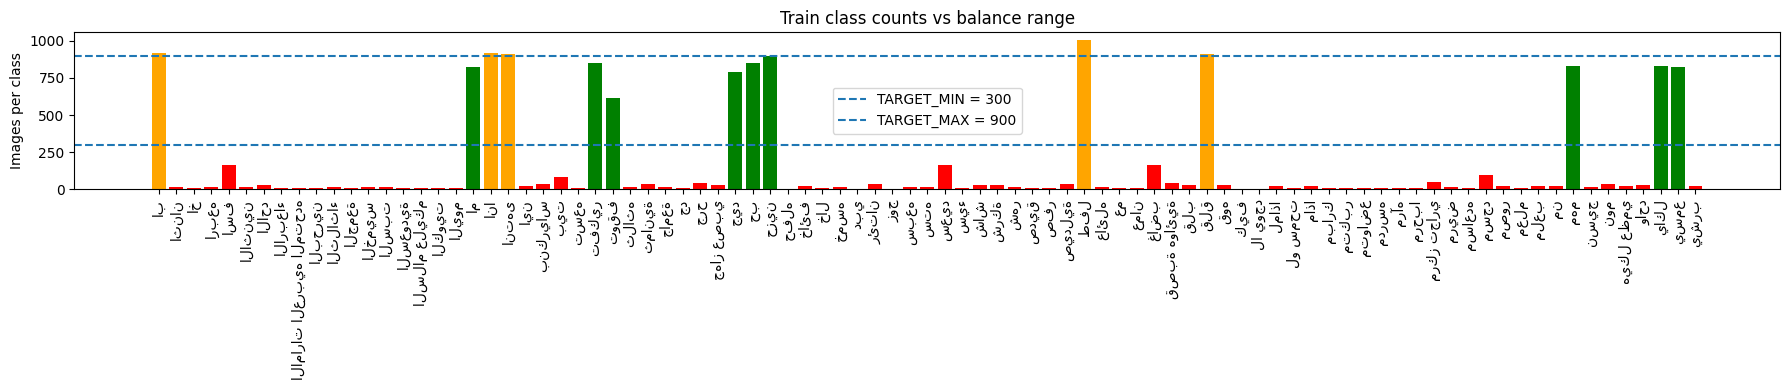

In [120]:
import numpy as np
import matplotlib.pyplot as plt

classes = df_tr["class"].tolist()
counts  = df_tr["count"].values
x = np.arange(len(df_tr))

# تأكيد وجود الأهداف
target_min = TARGET_MIN
target_max = TARGET_MAX  # لو ما تبينه، احذفي هالسطر وخط الكود حقه تحت

# تلوين الأعمدة حسب وضع الكلاس
colors = []
for c in counts:
    if c < target_min:
        colors.append("red")        # أقل من الحد الأدنى
    elif c > target_max:
        colors.append("orange")     # أعلى من الحد الأقصى
    else:
        colors.append("green")      # داخل النطاق المثالي

plt.figure(figsize=(18, 4))
plt.bar(x, counts, color=colors)
plt.xticks(x, classes, rotation=90)

# خط الحد الأدنى
plt.axhline(target_min, linestyle="--", label=f"TARGET_MIN = {target_min}")

# خط الحد الأقصى
plt.axhline(target_max, linestyle="--", label=f"TARGET_MAX = {target_max}")

plt.title("Train class counts vs balance range")
plt.ylabel("Images per class")
plt.legend()
plt.tight_layout()
plt.show()

In [121]:
low_classes = df_tr[df_tr["count"] < TARGET_MIN].sort_values("count")

print(f"Classes below TARGET_MIN ({TARGET_MIN}): {len(low_classes)}")
display(low_classes)

Classes below TARGET_MIN (300): 75


,class,count
42,زوج,3
62,كيف,5
63,لا يوجد,5
36,حفله,6
40,دبي,6
56,عمان,8
68,متكبر,8
69,متواضع,8
55,عم,9
14,السعودية,9


In [122]:
TRAIN_ROOT = SPLIT_DIR / "train"
TARGET = TARGET_MIN

# الكلاسات الناقصة
low_classes = df_tr[df_tr["count"] < TARGET].sort_values("count")
print(f"Will augment {len(low_classes)} classes up to {TARGET} images")
display(low_classes)

for _, row in low_classes.iterrows():
    cls_name = row["class"]
    cls_dir = TRAIN_ROOT / cls_name

    imgs = [p for p in cls_dir.iterdir() if is_img(p)]
    cur = len(imgs)
    if cur >= TARGET:
        continue  # احتياط

    # نستخدم فقط الصور الأصلية (بدون _aug_) كمصدر
    base_imgs = [p for p in imgs if "_aug_" not in p.stem]
    if not base_imgs:
        base_imgs = imgs  # احتياط

    need = TARGET - cur
    idx = 0

    from tqdm import tqdm

    with tqdm(total=need, desc=f"Augment {cls_name}") as bar:
        while cur < TARGET and base_imgs:
            src = base_imgs[idx % len(base_imgs)]
            im = cv2.imread(str(src), cv2.IMREAD_GRAYSCALE)
            if im is None:
                idx += 1
                continue

            aug = safe_augment(im)

            out_name = f"{src.stem}_aug_{cur}.png"
            out_path = cls_dir / out_name

            if out_path.exists():
                idx += 1
                continue

            cv2.imwrite(str(out_path), aug)
            cur += 1
            idx += 1
            bar.update(1)

print("[INFO] Augmentation for low classes finished.")

# تحديث df_tr بعد الرفع
df_tr = count_split("train")
print("New train total:", int(df_tr["count"].sum()))

Will augment 75 classes up to 300 images


,class,count
42,زوج,3
62,كيف,5
63,لا يوجد,5
36,حفله,6
40,دبي,6
56,عمان,8
68,متكبر,8
69,متواضع,8
55,عم,9
14,السعودية,9


Augment سعيد: 100%|██████████| 135/135 [00:00<00:00, 3864.87it/s]


[INFO] Augmentation for low classes finished.
New train total: 34452


In [123]:
# إعادة حساب توزيع train بعد الرفع
df_tr = count_split("train")

print("New train total:", int(df_tr["count"].sum()))
print("Min count:", int(df_tr["count"].min()))
print("Max count:", int(df_tr["count"].max()))

# الكلاسات اللي ما وصلت الهدف (لو باقي فيه شيء)
low_classes = df_tr[df_tr["count"] < TARGET_MIN].sort_values("count")

if low_classes.empty:
    print(f"✅ All classes are >= TARGET_MIN ({TARGET_MIN}).")
else:
    print(f"⚠️ Classes still below TARGET_MIN ({TARGET_MIN}): {len(low_classes)}")
    display(low_classes)

# جدول يوضح نسبة كل كلاس من الهدف
df_tr_check = df_tr.copy()
df_tr_check["% of TARGET_MIN"] = (df_tr_check["count"] / TARGET_MIN * 100).round(1)
display(df_tr_check.sort_values("count").head(20))  # أضعف 20 كلاس كفحص سريع

New train total: 34452
Min count: 300
Max count: 1006
✅ All classes are >= TARGET_MIN (300).


,class,count,% of TARGET_MIN
44,سته,300,100.0
63,لا يوجد,300,100.0
62,كيف,300,100.0
61,قوه,300,100.0
59,قلب,300,100.0
58,قصبة هوائية,300,100.0
57,غاضب,300,100.0
56,عمان,300,100.0
55,عم,300,100.0
54,عائله,300,100.0


In [124]:
# نفترض أن SPLIT_DIR و count_split معرفين

df_tr = count_split("train")

print("Number of classes:", len(df_tr))
print("Total train images:", int(df_tr["count"].sum()))

# عرض كل الكلاسات مع عدد الصور
display(df_tr)

Number of classes: 89
Total train images: 34452


,class,count
0,اب,914
1,اثنان,300
2,اخ,300
3,اربعه,300
4,اسف,300
5,الاثنين,300
6,الاحد,300
7,الاربعاء,300
8,الامارات العربيه المتحده,300
9,البحرين,300


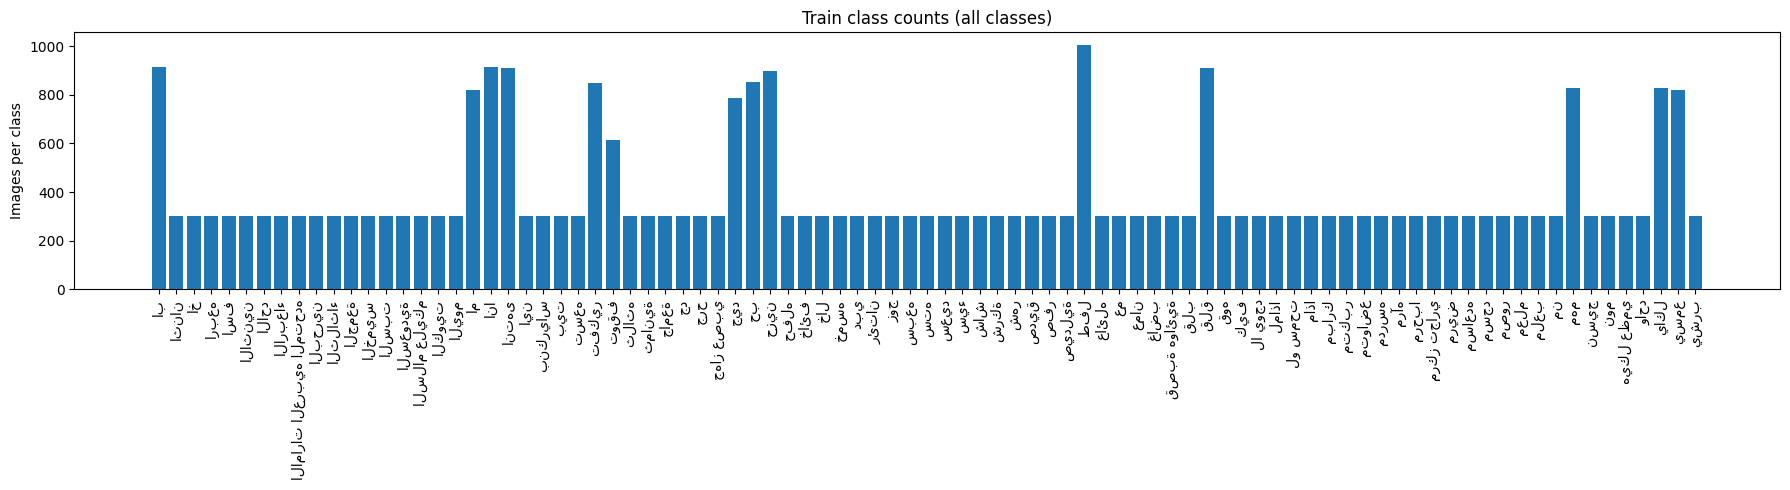

In [125]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(df_tr))

plt.figure(figsize=(18, 5))
plt.bar(x, df_tr["count"].values)
plt.xticks(x, df_tr["class"].tolist(), rotation=90)
plt.ylabel("Images per class")
plt.title("Train class counts (all classes)")
plt.tight_layout()
plt.show()